# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

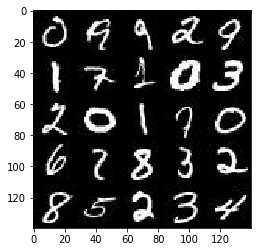

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

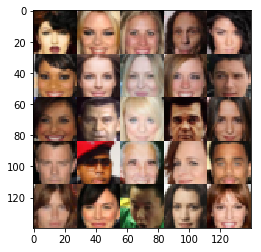

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_images   = tf.placeholder(tf.float32, name="input_real",    shape=(None, image_width, image_height, image_channels))
    z_data        = tf.placeholder(tf.float32, name="input_z",       shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, name="learning_rate", shape=None)

    return real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
import numpy as np

def leaky_relu(x, alpha):
    return tf.maximum(x*alpha, x)
    
def batch_norm(x, training):
    return tf.layers.batch_normalization(x, training=training)

def batch_norm_and_leaky_relu(x, alpha, training):
    if training != None:
        x = batch_norm(x, training)
    if alpha != None:
        x = leaky_relu(x, alpha)
    return x


def avg_pool(x, pool_ksize, pool_strides, padding='same'):
    return tf.layers.average_pooling2d(x, pool_ksize, pool_strides, padding=padding)


def out_and_logits_flattened(x, shape):
    y = tf.reshape(x, (-1, np.prod(shape)))
    
    logits = tf.layers.dense(y, 1)
    out    = tf.sigmoid(logits)
    return out, logits
    
def fully_connected_reshaped(x, shape, reshape=True, activation=None):
    y = tf.layers.dense(x, np.prod(shape), activation=activation)
    if reshape == True:
        y = tf.reshape(y, (-1,shape[0],shape[1],shape[2]))
    return y
    

def conv2d(x, alpha, training, filters, kernel_size=5, strides=2, padding='same', activation=None):
    y = tf.layers.conv2d(x, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation, kernel_initializer=tf.contrib.layers.xavier_initializer()) # tf.random_normal_initializer(mean=0.0, stddev=0.02)) # kernel_initializer=tf.random_normal_initializer(stddev=0.05))
    y = batch_norm_and_leaky_relu(y, alpha, training)
    return y

def deconv2d(x, alpha, training, filters, kernel=5, strides=2, padding='same'):
    y = tf.layers.conv2d_transpose(x, filters, kernel, strides=strides, padding=padding) # , kernel_initializer=tf.random_normal_initializer(stddev=0.05))
    y = batch_norm_and_leaky_relu(y, alpha, training)
    return y


In [7]:
def inception_module_leaky_relu(x, func, alpha, training, out_depth, dims, axis=3):
    convs = []
    for dim in dims:
        conv_ksize       = dim[0]
        conv_strides     = dim[1]
        
        layer = func(x, None, None,  out_depth, conv_ksize, conv_strides)
        
        convs.append( layer )
    inception = tf.concat(convs, axis) # tf.concat(axis, convs)
    
    if training != None:
        inception = batch_norm(inception, training)
    if alpha != None:
        inception = leaky_relu(inception, alpha)
    return inception

def inception_module_leaky_relu_default(x, func, alpha, training, out_depth, strides=1, axis=3):
    inception = inception_module_leaky_relu(x, func, alpha, training, out_depth, [(1,strides),(3,strides),(5,strides)], axis)
    return inception

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
#def discriminator(images, reuse=False):
def discriminator(images, reuse=False, alpha=0.2, dropout=0.9):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    training=True
    with tf.variable_scope('discriminator', reuse=reuse):        
        x = images
        
        x = conv2d(x, alpha, None,      64, 3, 1)   #without batch_norm
        
        x = tf.layers.dropout(x, dropout)
        
        x = conv2d(x, alpha, training, 128, 5, 2)
        x = conv2d(x, alpha, training, 256, 5, 2)
        #x = conv2d(x, alpha, training, 512, 5, 2)
        
        x = tf.layers.dropout(x, dropout)
        
        flatshape = x.get_shape().as_list()[1:]
        return out_and_logits_flattened(x, flatshape)
    
    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
#def generator(z, out_channel_dim, is_train=True):
def generator(z, out_channel_dim, is_train=True, alpha=0.2, dropout=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        x = z        
        x = fully_connected_reshaped (x, (7, 7, 512))
        x = batch_norm_and_leaky_relu(x, alpha, is_train)
        
        x = tf.layers.dropout(x, dropout)
                
        x = deconv2d(x, alpha, is_train, 256, 1, 1)
        x = deconv2d(x, alpha, is_train, 128, 5, 2)
        
        x = tf.layers.dropout(x, dropout)
        
        logits = deconv2d(x, None, None, out_channel_dim, 5, 2)   #without batch_norm and without leakyrelu
        out    = tf.tanh(logits)
        
        return out
        
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
#def model_loss(input_real, input_z, out_channel_dim):
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model                     = generator    (input_z, output_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=None, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model,    reuse=True, alpha=alpha)
    
    d_real_loss_labels = tf.ones_like  (d_model_real)*0.9 #*0.88
    d_fake_loss_labels = tf.zeros_like (d_model_fake)
    g_fake_loss_labels = tf.ones_like  (d_model_fake)     #*0.98
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=d_real_loss_labels))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=d_fake_loss_labels))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=g_fake_loss_labels))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    pyplot.clf()
    pyplot.cla()
    pyplot.close()

In [13]:
def show_losses_graph(losses):
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()
    #pyplot.gcf().clear()

    pyplot.clf()
    pyplot.cla()
    pyplot.close()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, n_images=4, print_every=100, show_every=500, show_graph_every = None, min_losses_graph=15):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    alpha = 0.2
    
    num_of_batches = data_shape[0]
    image_width    = data_shape[1] # 28
    image_height   = data_shape[2] # 28
    image_channels = data_shape[3] # 1 or 3 channels (mono or rgb)
    
    print(data_shape)
    
    #tf.reset_default_graph()
    input_real, input_z, input_lr = model_inputs(image_width, image_height, image_channels, z_dim)
        
    d_loss, g_loss = model_loss (input_real, input_z, image_channels, alpha=alpha)
    d_opt,  g_opt  = model_opt  (d_loss, g_loss, input_lr, beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    steps = 0
                                
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                batch_images = batch_images * 2 # + np.random.uniform(-0.00075, 0.00075, size=batch_images.shape)
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_lr:learning_rate, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_lr:learning_rate, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_lr:learning_rate, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} , ".format(epoch_i+1, epochs),
                          "Batch {}/{} : ".format((steps*batch_size)%num_of_batches, num_of_batches),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
                how_many_losses = steps / print_every # or len(losses)
                if (show_graph_every != None) and (how_many_losses>min_losses_graph) and (steps % show_graph_every == 0):
                    print("GRAPH:")
                    show_losses_graph(losses)
                    
            print("EPOCH {}/{}, generations: ".format(epoch_i+1, epochs))
            show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
            show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
            show_generator_output(sess,  8, input_z, image_channels, data_image_mode)
            show_generator_output(sess,  1, input_z, image_channels, data_image_mode)
                    
        show_losses_graph(losses)
        saver.save(sess, './generator.ckpt')
    
    return losses
            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2 ,  Batch 500/60000 :  Discriminator Loss: 3.2952... Generator Loss: 0.0645
Epoch 1/2 ,  Batch 1000/60000 :  Discriminator Loss: 2.4940... Generator Loss: 0.1395
Epoch 1/2 ,  Batch 1500/60000 :  Discriminator Loss: 1.5920... Generator Loss: 0.3931
Epoch 1/2 ,  Batch 2000/60000 :  Discriminator Loss: 2.4051... Generator Loss: 0.1687
Epoch 1/2 ,  Batch 2500/60000 :  Discriminator Loss: 1.3023... Generator Loss: 0.6798
Epoch 1/2 ,  Batch 3000/60000 :  Discriminator Loss: 1.7214... Generator Loss: 0.3230
Epoch 1/2 ,  Batch 3500/60000 :  Discriminator Loss: 2.3274... Generator Loss: 0.2247
Epoch 1/2 ,  Batch 4000/60000 :  Discriminator Loss: 1.2472... Generator Loss: 0.6447
Epoch 1/2 ,  Batch 4500/60000 :  Discriminator Loss: 1.0937... Generator Loss: 1.4660
Epoch 1/2 ,  Batch 5000/60000 :  Discriminator Loss: 1.0313... Generator Loss: 0.9567


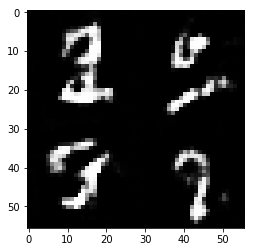

Epoch 1/2 ,  Batch 5500/60000 :  Discriminator Loss: 1.0308... Generator Loss: 0.8901
Epoch 1/2 ,  Batch 6000/60000 :  Discriminator Loss: 1.2469... Generator Loss: 0.6590
Epoch 1/2 ,  Batch 6500/60000 :  Discriminator Loss: 1.6969... Generator Loss: 0.3818
Epoch 1/2 ,  Batch 7000/60000 :  Discriminator Loss: 1.1899... Generator Loss: 1.1011
Epoch 1/2 ,  Batch 7500/60000 :  Discriminator Loss: 1.2550... Generator Loss: 0.5930
Epoch 1/2 ,  Batch 8000/60000 :  Discriminator Loss: 1.3288... Generator Loss: 0.5723
Epoch 1/2 ,  Batch 8500/60000 :  Discriminator Loss: 0.8411... Generator Loss: 1.2595
Epoch 1/2 ,  Batch 9000/60000 :  Discriminator Loss: 1.0866... Generator Loss: 1.9011
Epoch 1/2 ,  Batch 9500/60000 :  Discriminator Loss: 1.4839... Generator Loss: 0.5772
Epoch 1/2 ,  Batch 10000/60000 :  Discriminator Loss: 1.4767... Generator Loss: 0.4348


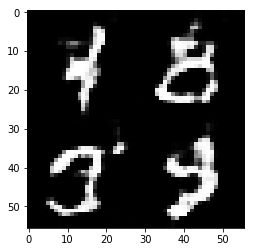

Epoch 1/2 ,  Batch 10500/60000 :  Discriminator Loss: 0.9636... Generator Loss: 0.9033
Epoch 1/2 ,  Batch 11000/60000 :  Discriminator Loss: 1.7768... Generator Loss: 0.3541
Epoch 1/2 ,  Batch 11500/60000 :  Discriminator Loss: 1.0345... Generator Loss: 0.8229
Epoch 1/2 ,  Batch 12000/60000 :  Discriminator Loss: 1.2568... Generator Loss: 0.6232
Epoch 1/2 ,  Batch 12500/60000 :  Discriminator Loss: 1.6492... Generator Loss: 0.3328
Epoch 1/2 ,  Batch 13000/60000 :  Discriminator Loss: 1.5003... Generator Loss: 0.4470
Epoch 1/2 ,  Batch 13500/60000 :  Discriminator Loss: 0.7117... Generator Loss: 2.1415
Epoch 1/2 ,  Batch 14000/60000 :  Discriminator Loss: 2.2935... Generator Loss: 0.1791
Epoch 1/2 ,  Batch 14500/60000 :  Discriminator Loss: 1.8842... Generator Loss: 0.2970
Epoch 1/2 ,  Batch 15000/60000 :  Discriminator Loss: 0.8389... Generator Loss: 1.1036


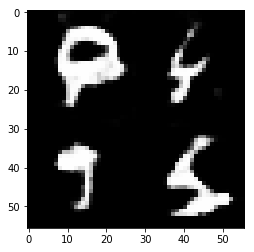

GRAPH:


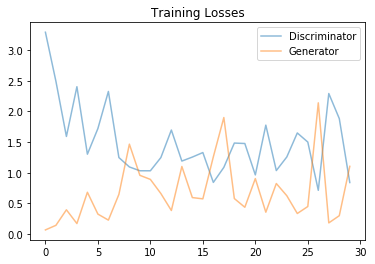

Epoch 1/2 ,  Batch 15500/60000 :  Discriminator Loss: 0.8965... Generator Loss: 0.8612
Epoch 1/2 ,  Batch 16000/60000 :  Discriminator Loss: 3.2694... Generator Loss: 0.0787
Epoch 1/2 ,  Batch 16500/60000 :  Discriminator Loss: 1.1305... Generator Loss: 0.7291
Epoch 1/2 ,  Batch 17000/60000 :  Discriminator Loss: 0.9279... Generator Loss: 0.9309
Epoch 1/2 ,  Batch 17500/60000 :  Discriminator Loss: 0.9837... Generator Loss: 0.9286
Epoch 1/2 ,  Batch 18000/60000 :  Discriminator Loss: 0.6407... Generator Loss: 1.6997
Epoch 1/2 ,  Batch 18500/60000 :  Discriminator Loss: 1.6539... Generator Loss: 0.3413
Epoch 1/2 ,  Batch 19000/60000 :  Discriminator Loss: 0.8063... Generator Loss: 1.1271
Epoch 1/2 ,  Batch 19500/60000 :  Discriminator Loss: 0.7364... Generator Loss: 1.6098
Epoch 1/2 ,  Batch 20000/60000 :  Discriminator Loss: 0.5567... Generator Loss: 2.0277


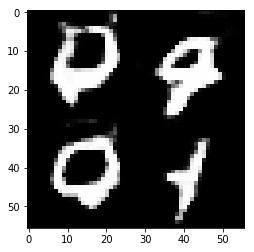

Epoch 1/2 ,  Batch 20500/60000 :  Discriminator Loss: 0.6927... Generator Loss: 1.3876
Epoch 1/2 ,  Batch 21000/60000 :  Discriminator Loss: 1.1477... Generator Loss: 0.6615
Epoch 1/2 ,  Batch 21500/60000 :  Discriminator Loss: 0.5947... Generator Loss: 1.8666
Epoch 1/2 ,  Batch 22000/60000 :  Discriminator Loss: 0.7019... Generator Loss: 1.3806
Epoch 1/2 ,  Batch 22500/60000 :  Discriminator Loss: 0.8474... Generator Loss: 1.1089
Epoch 1/2 ,  Batch 23000/60000 :  Discriminator Loss: 1.9521... Generator Loss: 0.2635
Epoch 1/2 ,  Batch 23500/60000 :  Discriminator Loss: 0.5965... Generator Loss: 1.8110
Epoch 1/2 ,  Batch 24000/60000 :  Discriminator Loss: 0.8626... Generator Loss: 0.9999
Epoch 1/2 ,  Batch 24500/60000 :  Discriminator Loss: 1.1298... Generator Loss: 0.7696
Epoch 1/2 ,  Batch 25000/60000 :  Discriminator Loss: 1.5669... Generator Loss: 0.4559


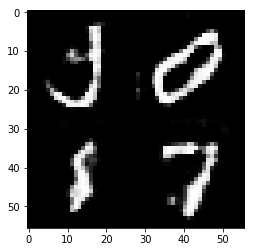

Epoch 1/2 ,  Batch 25500/60000 :  Discriminator Loss: 1.1864... Generator Loss: 0.6626
Epoch 1/2 ,  Batch 26000/60000 :  Discriminator Loss: 0.9069... Generator Loss: 1.0263
Epoch 1/2 ,  Batch 26500/60000 :  Discriminator Loss: 1.0187... Generator Loss: 0.7886
Epoch 1/2 ,  Batch 27000/60000 :  Discriminator Loss: 0.9494... Generator Loss: 0.8958
Epoch 1/2 ,  Batch 27500/60000 :  Discriminator Loss: 0.8253... Generator Loss: 1.1750
Epoch 1/2 ,  Batch 28000/60000 :  Discriminator Loss: 0.6710... Generator Loss: 1.4404
Epoch 1/2 ,  Batch 28500/60000 :  Discriminator Loss: 0.5922... Generator Loss: 1.6582
Epoch 1/2 ,  Batch 29000/60000 :  Discriminator Loss: 0.7087... Generator Loss: 1.3450
Epoch 1/2 ,  Batch 29500/60000 :  Discriminator Loss: 0.7166... Generator Loss: 1.2552
Epoch 1/2 ,  Batch 30000/60000 :  Discriminator Loss: 0.6668... Generator Loss: 1.7185


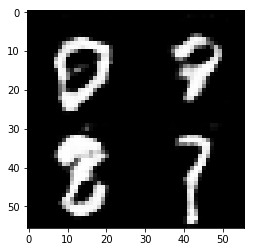

GRAPH:


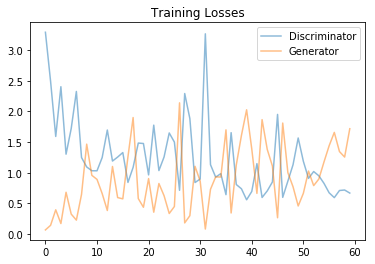

Epoch 1/2 ,  Batch 30500/60000 :  Discriminator Loss: 1.0663... Generator Loss: 0.7240
Epoch 1/2 ,  Batch 31000/60000 :  Discriminator Loss: 0.5697... Generator Loss: 1.9113
Epoch 1/2 ,  Batch 31500/60000 :  Discriminator Loss: 1.5959... Generator Loss: 2.0030
Epoch 1/2 ,  Batch 32000/60000 :  Discriminator Loss: 0.9916... Generator Loss: 0.8874
Epoch 1/2 ,  Batch 32500/60000 :  Discriminator Loss: 1.5641... Generator Loss: 0.4799
Epoch 1/2 ,  Batch 33000/60000 :  Discriminator Loss: 0.7013... Generator Loss: 1.3431
Epoch 1/2 ,  Batch 33500/60000 :  Discriminator Loss: 0.5171... Generator Loss: 2.0525
Epoch 1/2 ,  Batch 34000/60000 :  Discriminator Loss: 0.9363... Generator Loss: 0.9297
Epoch 1/2 ,  Batch 34500/60000 :  Discriminator Loss: 0.8393... Generator Loss: 1.0233
Epoch 1/2 ,  Batch 35000/60000 :  Discriminator Loss: 0.5832... Generator Loss: 1.6793


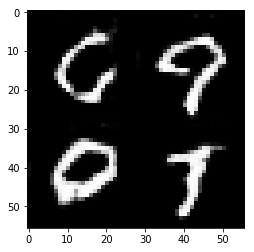

Epoch 1/2 ,  Batch 35500/60000 :  Discriminator Loss: 0.6374... Generator Loss: 2.1637
Epoch 1/2 ,  Batch 36000/60000 :  Discriminator Loss: 0.5150... Generator Loss: 2.1557
Epoch 1/2 ,  Batch 36500/60000 :  Discriminator Loss: 0.6182... Generator Loss: 1.5568
Epoch 1/2 ,  Batch 37000/60000 :  Discriminator Loss: 0.4696... Generator Loss: 2.1406
Epoch 1/2 ,  Batch 37500/60000 :  Discriminator Loss: 0.4649... Generator Loss: 2.3253
Epoch 1/2 ,  Batch 38000/60000 :  Discriminator Loss: 1.2239... Generator Loss: 0.6499
Epoch 1/2 ,  Batch 38500/60000 :  Discriminator Loss: 0.5747... Generator Loss: 2.0293
Epoch 1/2 ,  Batch 39000/60000 :  Discriminator Loss: 0.6820... Generator Loss: 1.4511
Epoch 1/2 ,  Batch 39500/60000 :  Discriminator Loss: 0.4853... Generator Loss: 2.4450
Epoch 1/2 ,  Batch 40000/60000 :  Discriminator Loss: 0.6083... Generator Loss: 1.4939


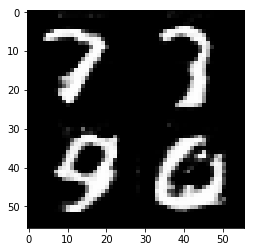

Epoch 1/2 ,  Batch 40500/60000 :  Discriminator Loss: 0.5977... Generator Loss: 1.7186
Epoch 1/2 ,  Batch 41000/60000 :  Discriminator Loss: 0.4890... Generator Loss: 2.1749
Epoch 1/2 ,  Batch 41500/60000 :  Discriminator Loss: 0.9041... Generator Loss: 0.9436
Epoch 1/2 ,  Batch 42000/60000 :  Discriminator Loss: 0.7378... Generator Loss: 1.3997
Epoch 1/2 ,  Batch 42500/60000 :  Discriminator Loss: 1.1091... Generator Loss: 0.7905
Epoch 1/2 ,  Batch 43000/60000 :  Discriminator Loss: 1.0310... Generator Loss: 0.8673
Epoch 1/2 ,  Batch 43500/60000 :  Discriminator Loss: 0.6456... Generator Loss: 1.4104
Epoch 1/2 ,  Batch 44000/60000 :  Discriminator Loss: 0.9826... Generator Loss: 0.8587
Epoch 1/2 ,  Batch 44500/60000 :  Discriminator Loss: 0.4629... Generator Loss: 2.4179
Epoch 1/2 ,  Batch 45000/60000 :  Discriminator Loss: 0.7663... Generator Loss: 1.1981


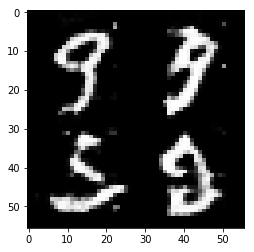

GRAPH:


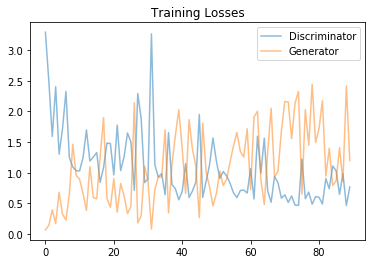

Epoch 1/2 ,  Batch 45500/60000 :  Discriminator Loss: 0.8001... Generator Loss: 1.1923
Epoch 1/2 ,  Batch 46000/60000 :  Discriminator Loss: 1.4840... Generator Loss: 0.5238
Epoch 1/2 ,  Batch 46500/60000 :  Discriminator Loss: 0.9113... Generator Loss: 0.9121
Epoch 1/2 ,  Batch 47000/60000 :  Discriminator Loss: 0.7055... Generator Loss: 1.3548
Epoch 1/2 ,  Batch 47500/60000 :  Discriminator Loss: 0.7758... Generator Loss: 1.1384
Epoch 1/2 ,  Batch 48000/60000 :  Discriminator Loss: 0.6593... Generator Loss: 2.9101
Epoch 1/2 ,  Batch 48500/60000 :  Discriminator Loss: 2.5144... Generator Loss: 0.1678
Epoch 1/2 ,  Batch 49000/60000 :  Discriminator Loss: 0.7578... Generator Loss: 1.4667
Epoch 1/2 ,  Batch 49500/60000 :  Discriminator Loss: 1.2052... Generator Loss: 0.6092
Epoch 1/2 ,  Batch 50000/60000 :  Discriminator Loss: 0.5172... Generator Loss: 2.0131


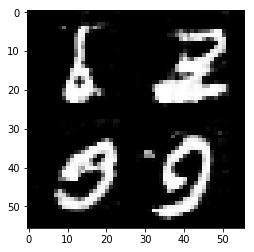

Epoch 1/2 ,  Batch 50500/60000 :  Discriminator Loss: 0.6810... Generator Loss: 1.3248
Epoch 1/2 ,  Batch 51000/60000 :  Discriminator Loss: 0.8453... Generator Loss: 1.0430
Epoch 1/2 ,  Batch 51500/60000 :  Discriminator Loss: 0.9586... Generator Loss: 0.8965
Epoch 1/2 ,  Batch 52000/60000 :  Discriminator Loss: 0.9981... Generator Loss: 0.9129
Epoch 1/2 ,  Batch 52500/60000 :  Discriminator Loss: 0.4880... Generator Loss: 2.1248
Epoch 1/2 ,  Batch 53000/60000 :  Discriminator Loss: 0.6857... Generator Loss: 1.3875
Epoch 1/2 ,  Batch 53500/60000 :  Discriminator Loss: 0.8007... Generator Loss: 1.2071
Epoch 1/2 ,  Batch 54000/60000 :  Discriminator Loss: 0.8857... Generator Loss: 0.9762
Epoch 1/2 ,  Batch 54500/60000 :  Discriminator Loss: 1.1141... Generator Loss: 0.6568
Epoch 1/2 ,  Batch 55000/60000 :  Discriminator Loss: 3.2203... Generator Loss: 0.1357


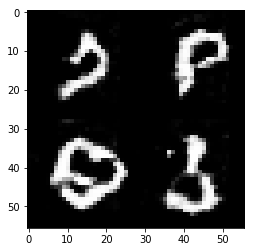

Epoch 1/2 ,  Batch 55500/60000 :  Discriminator Loss: 0.5426... Generator Loss: 1.8828
Epoch 1/2 ,  Batch 56000/60000 :  Discriminator Loss: 0.6622... Generator Loss: 1.7046
Epoch 1/2 ,  Batch 56500/60000 :  Discriminator Loss: 0.7445... Generator Loss: 1.1970
Epoch 1/2 ,  Batch 57000/60000 :  Discriminator Loss: 0.9047... Generator Loss: 0.9791
Epoch 1/2 ,  Batch 57500/60000 :  Discriminator Loss: 0.8908... Generator Loss: 1.0142
Epoch 1/2 ,  Batch 58000/60000 :  Discriminator Loss: 0.6062... Generator Loss: 1.5438
Epoch 1/2 ,  Batch 58500/60000 :  Discriminator Loss: 0.4985... Generator Loss: 2.0436
Epoch 1/2 ,  Batch 59000/60000 :  Discriminator Loss: 0.7728... Generator Loss: 1.4797
Epoch 1/2 ,  Batch 59500/60000 :  Discriminator Loss: 0.9527... Generator Loss: 0.8534
Epoch 1/2 ,  Batch 0/60000 :  Discriminator Loss: 0.5570... Generator Loss: 1.7742


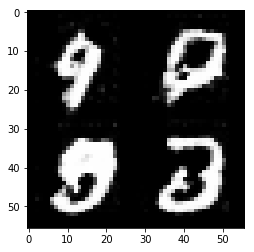

GRAPH:


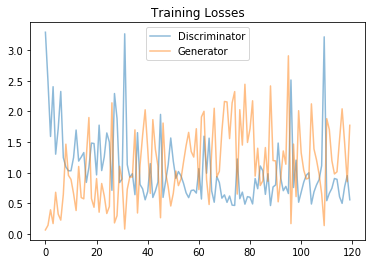

EPOCH 1/2, generations: 


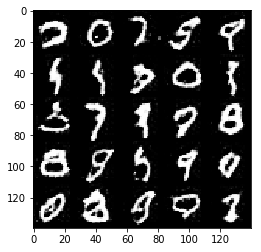

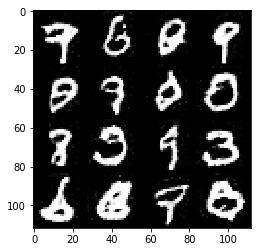

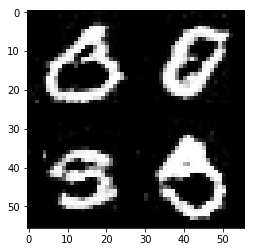

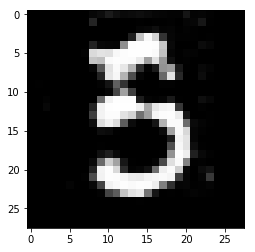

Epoch 2/2 ,  Batch 500/60000 :  Discriminator Loss: 0.5126... Generator Loss: 2.0204
Epoch 2/2 ,  Batch 1000/60000 :  Discriminator Loss: 1.1161... Generator Loss: 0.7427
Epoch 2/2 ,  Batch 1500/60000 :  Discriminator Loss: 0.9907... Generator Loss: 0.8816
Epoch 2/2 ,  Batch 2000/60000 :  Discriminator Loss: 1.0794... Generator Loss: 0.9666
Epoch 2/2 ,  Batch 2500/60000 :  Discriminator Loss: 0.8892... Generator Loss: 0.9797
Epoch 2/2 ,  Batch 3000/60000 :  Discriminator Loss: 0.8166... Generator Loss: 1.1193
Epoch 2/2 ,  Batch 3500/60000 :  Discriminator Loss: 1.3264... Generator Loss: 0.5953
Epoch 2/2 ,  Batch 4000/60000 :  Discriminator Loss: 0.8849... Generator Loss: 1.0459
Epoch 2/2 ,  Batch 4500/60000 :  Discriminator Loss: 1.4701... Generator Loss: 0.4880
Epoch 2/2 ,  Batch 5000/60000 :  Discriminator Loss: 1.8419... Generator Loss: 0.3059


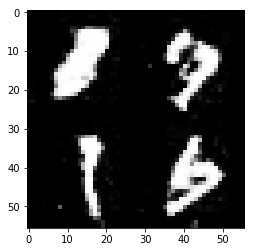

Epoch 2/2 ,  Batch 5500/60000 :  Discriminator Loss: 0.6826... Generator Loss: 1.4581
Epoch 2/2 ,  Batch 6000/60000 :  Discriminator Loss: 0.9776... Generator Loss: 0.9273
Epoch 2/2 ,  Batch 6500/60000 :  Discriminator Loss: 0.6899... Generator Loss: 1.2979
Epoch 2/2 ,  Batch 7000/60000 :  Discriminator Loss: 1.0015... Generator Loss: 0.9039
Epoch 2/2 ,  Batch 7500/60000 :  Discriminator Loss: 0.5616... Generator Loss: 1.9380
Epoch 2/2 ,  Batch 8000/60000 :  Discriminator Loss: 0.9236... Generator Loss: 1.0448
Epoch 2/2 ,  Batch 8500/60000 :  Discriminator Loss: 1.2923... Generator Loss: 0.5932
Epoch 2/2 ,  Batch 9000/60000 :  Discriminator Loss: 1.9193... Generator Loss: 0.3438
Epoch 2/2 ,  Batch 9500/60000 :  Discriminator Loss: 0.9490... Generator Loss: 0.9153
Epoch 2/2 ,  Batch 10000/60000 :  Discriminator Loss: 1.0232... Generator Loss: 0.8352


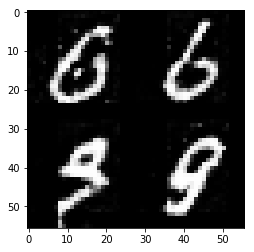

Epoch 2/2 ,  Batch 10500/60000 :  Discriminator Loss: 1.1547... Generator Loss: 0.7125
Epoch 2/2 ,  Batch 11000/60000 :  Discriminator Loss: 1.6605... Generator Loss: 0.3643
Epoch 2/2 ,  Batch 11500/60000 :  Discriminator Loss: 1.2188... Generator Loss: 3.1780
Epoch 2/2 ,  Batch 12000/60000 :  Discriminator Loss: 0.6652... Generator Loss: 1.4865
Epoch 2/2 ,  Batch 12500/60000 :  Discriminator Loss: 1.4818... Generator Loss: 0.4735
Epoch 2/2 ,  Batch 13000/60000 :  Discriminator Loss: 1.3766... Generator Loss: 0.4764
Epoch 2/2 ,  Batch 13500/60000 :  Discriminator Loss: 0.8117... Generator Loss: 1.1593
Epoch 2/2 ,  Batch 14000/60000 :  Discriminator Loss: 1.3143... Generator Loss: 0.5487
Epoch 2/2 ,  Batch 14500/60000 :  Discriminator Loss: 0.6947... Generator Loss: 1.4586
Epoch 2/2 ,  Batch 15000/60000 :  Discriminator Loss: 0.8242... Generator Loss: 1.0808


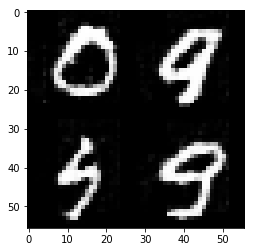

GRAPH:


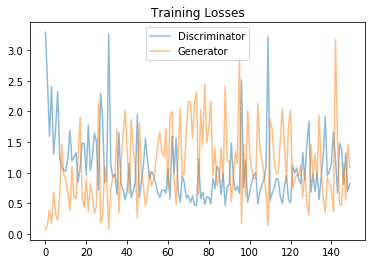

Epoch 2/2 ,  Batch 15500/60000 :  Discriminator Loss: 1.4862... Generator Loss: 0.4557
Epoch 2/2 ,  Batch 16000/60000 :  Discriminator Loss: 0.6860... Generator Loss: 1.3484
Epoch 2/2 ,  Batch 16500/60000 :  Discriminator Loss: 0.9863... Generator Loss: 0.8030
Epoch 2/2 ,  Batch 17000/60000 :  Discriminator Loss: 0.9381... Generator Loss: 0.9618
Epoch 2/2 ,  Batch 17500/60000 :  Discriminator Loss: 1.0151... Generator Loss: 0.9574
Epoch 2/2 ,  Batch 18000/60000 :  Discriminator Loss: 1.0101... Generator Loss: 0.8695
Epoch 2/2 ,  Batch 18500/60000 :  Discriminator Loss: 1.3134... Generator Loss: 0.6381
Epoch 2/2 ,  Batch 19000/60000 :  Discriminator Loss: 1.0400... Generator Loss: 0.9139
Epoch 2/2 ,  Batch 19500/60000 :  Discriminator Loss: 0.7976... Generator Loss: 1.3195
Epoch 2/2 ,  Batch 20000/60000 :  Discriminator Loss: 0.9129... Generator Loss: 0.9433


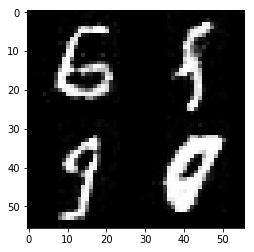

Epoch 2/2 ,  Batch 20500/60000 :  Discriminator Loss: 0.6567... Generator Loss: 1.5960
Epoch 2/2 ,  Batch 21000/60000 :  Discriminator Loss: 1.3244... Generator Loss: 0.5597
Epoch 2/2 ,  Batch 21500/60000 :  Discriminator Loss: 1.1562... Generator Loss: 0.7417
Epoch 2/2 ,  Batch 22000/60000 :  Discriminator Loss: 0.7392... Generator Loss: 1.3075
Epoch 2/2 ,  Batch 22500/60000 :  Discriminator Loss: 1.2953... Generator Loss: 0.6524
Epoch 2/2 ,  Batch 23000/60000 :  Discriminator Loss: 1.1135... Generator Loss: 0.7465
Epoch 2/2 ,  Batch 23500/60000 :  Discriminator Loss: 0.9831... Generator Loss: 0.8795
Epoch 2/2 ,  Batch 24000/60000 :  Discriminator Loss: 0.8305... Generator Loss: 1.1714
Epoch 2/2 ,  Batch 24500/60000 :  Discriminator Loss: 1.5610... Generator Loss: 0.6555
Epoch 2/2 ,  Batch 25000/60000 :  Discriminator Loss: 0.5555... Generator Loss: 1.8181


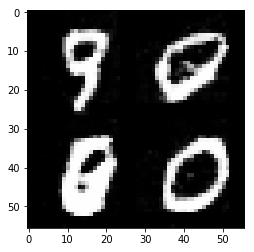

Epoch 2/2 ,  Batch 25500/60000 :  Discriminator Loss: 2.4819... Generator Loss: 0.1679
Epoch 2/2 ,  Batch 26000/60000 :  Discriminator Loss: 1.0094... Generator Loss: 0.9332
Epoch 2/2 ,  Batch 26500/60000 :  Discriminator Loss: 0.6783... Generator Loss: 1.3672
Epoch 2/2 ,  Batch 27000/60000 :  Discriminator Loss: 1.0853... Generator Loss: 0.8181
Epoch 2/2 ,  Batch 27500/60000 :  Discriminator Loss: 0.8493... Generator Loss: 1.0720
Epoch 2/2 ,  Batch 28000/60000 :  Discriminator Loss: 0.9838... Generator Loss: 0.8878
Epoch 2/2 ,  Batch 28500/60000 :  Discriminator Loss: 0.9326... Generator Loss: 0.8671
Epoch 2/2 ,  Batch 29000/60000 :  Discriminator Loss: 0.9683... Generator Loss: 0.9888
Epoch 2/2 ,  Batch 29500/60000 :  Discriminator Loss: 1.5948... Generator Loss: 0.4312
Epoch 2/2 ,  Batch 30000/60000 :  Discriminator Loss: 0.9642... Generator Loss: 0.8625


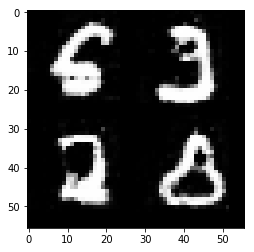

GRAPH:


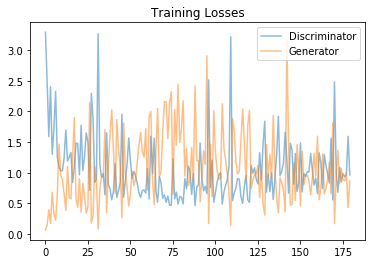

Epoch 2/2 ,  Batch 30500/60000 :  Discriminator Loss: 1.3265... Generator Loss: 0.5707
Epoch 2/2 ,  Batch 31000/60000 :  Discriminator Loss: 0.6371... Generator Loss: 1.8026
Epoch 2/2 ,  Batch 31500/60000 :  Discriminator Loss: 0.7151... Generator Loss: 1.3957
Epoch 2/2 ,  Batch 32000/60000 :  Discriminator Loss: 1.3307... Generator Loss: 0.4847
Epoch 2/2 ,  Batch 32500/60000 :  Discriminator Loss: 1.0749... Generator Loss: 0.7846
Epoch 2/2 ,  Batch 33000/60000 :  Discriminator Loss: 1.1185... Generator Loss: 0.7226
Epoch 2/2 ,  Batch 33500/60000 :  Discriminator Loss: 0.9728... Generator Loss: 0.8764
Epoch 2/2 ,  Batch 34000/60000 :  Discriminator Loss: 1.6663... Generator Loss: 0.3696
Epoch 2/2 ,  Batch 34500/60000 :  Discriminator Loss: 1.3427... Generator Loss: 0.5213
Epoch 2/2 ,  Batch 35000/60000 :  Discriminator Loss: 0.8996... Generator Loss: 1.1389


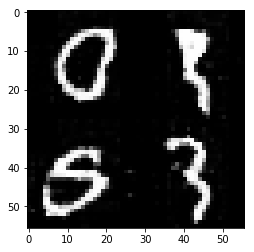

Epoch 2/2 ,  Batch 35500/60000 :  Discriminator Loss: 1.0159... Generator Loss: 0.8328
Epoch 2/2 ,  Batch 36000/60000 :  Discriminator Loss: 1.0885... Generator Loss: 0.6965
Epoch 2/2 ,  Batch 36500/60000 :  Discriminator Loss: 1.6254... Generator Loss: 0.4185
Epoch 2/2 ,  Batch 37000/60000 :  Discriminator Loss: 1.1222... Generator Loss: 0.7009
Epoch 2/2 ,  Batch 37500/60000 :  Discriminator Loss: 0.9806... Generator Loss: 0.9563
Epoch 2/2 ,  Batch 38000/60000 :  Discriminator Loss: 1.1738... Generator Loss: 0.8280
Epoch 2/2 ,  Batch 38500/60000 :  Discriminator Loss: 0.8846... Generator Loss: 1.0455
Epoch 2/2 ,  Batch 39000/60000 :  Discriminator Loss: 1.0670... Generator Loss: 0.7832
Epoch 2/2 ,  Batch 39500/60000 :  Discriminator Loss: 0.8469... Generator Loss: 1.1205
Epoch 2/2 ,  Batch 40000/60000 :  Discriminator Loss: 1.0353... Generator Loss: 0.9055


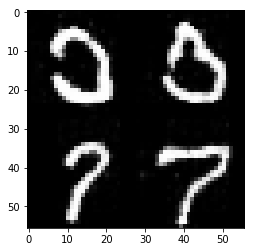

Epoch 2/2 ,  Batch 40500/60000 :  Discriminator Loss: 0.7929... Generator Loss: 1.2949
Epoch 2/2 ,  Batch 41000/60000 :  Discriminator Loss: 0.9450... Generator Loss: 0.9243
Epoch 2/2 ,  Batch 41500/60000 :  Discriminator Loss: 1.5881... Generator Loss: 0.4296
Epoch 2/2 ,  Batch 42000/60000 :  Discriminator Loss: 0.7977... Generator Loss: 1.1808
Epoch 2/2 ,  Batch 42500/60000 :  Discriminator Loss: 0.9029... Generator Loss: 1.0107
Epoch 2/2 ,  Batch 43000/60000 :  Discriminator Loss: 1.0513... Generator Loss: 0.8613
Epoch 2/2 ,  Batch 43500/60000 :  Discriminator Loss: 1.0882... Generator Loss: 0.7131
Epoch 2/2 ,  Batch 44000/60000 :  Discriminator Loss: 1.0531... Generator Loss: 0.7986
Epoch 2/2 ,  Batch 44500/60000 :  Discriminator Loss: 0.9658... Generator Loss: 0.9091
Epoch 2/2 ,  Batch 45000/60000 :  Discriminator Loss: 1.1477... Generator Loss: 0.7814


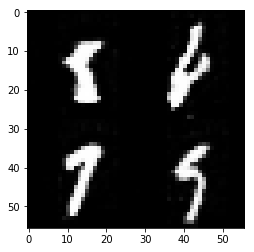

GRAPH:


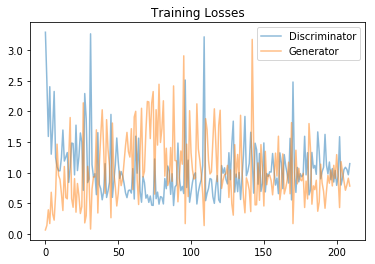

Epoch 2/2 ,  Batch 45500/60000 :  Discriminator Loss: 1.5718... Generator Loss: 0.5721
Epoch 2/2 ,  Batch 46000/60000 :  Discriminator Loss: 1.3549... Generator Loss: 0.5011
Epoch 2/2 ,  Batch 46500/60000 :  Discriminator Loss: 1.8883... Generator Loss: 0.4084
Epoch 2/2 ,  Batch 47000/60000 :  Discriminator Loss: 0.7707... Generator Loss: 1.2864
Epoch 2/2 ,  Batch 47500/60000 :  Discriminator Loss: 1.3863... Generator Loss: 0.7016
Epoch 2/2 ,  Batch 48000/60000 :  Discriminator Loss: 0.6666... Generator Loss: 1.4704
Epoch 2/2 ,  Batch 48500/60000 :  Discriminator Loss: 0.7075... Generator Loss: 1.4152
Epoch 2/2 ,  Batch 49000/60000 :  Discriminator Loss: 0.8876... Generator Loss: 1.0363
Epoch 2/2 ,  Batch 49500/60000 :  Discriminator Loss: 1.7383... Generator Loss: 0.3519
Epoch 2/2 ,  Batch 50000/60000 :  Discriminator Loss: 1.0756... Generator Loss: 0.7211


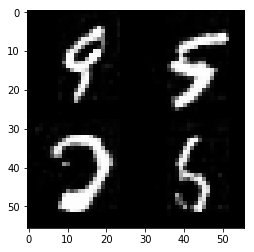

Epoch 2/2 ,  Batch 50500/60000 :  Discriminator Loss: 0.7022... Generator Loss: 1.4233
Epoch 2/2 ,  Batch 51000/60000 :  Discriminator Loss: 0.8656... Generator Loss: 1.0744
Epoch 2/2 ,  Batch 51500/60000 :  Discriminator Loss: 0.9505... Generator Loss: 0.8877
Epoch 2/2 ,  Batch 52000/60000 :  Discriminator Loss: 1.1570... Generator Loss: 0.7669
Epoch 2/2 ,  Batch 52500/60000 :  Discriminator Loss: 1.0114... Generator Loss: 0.8796
Epoch 2/2 ,  Batch 53000/60000 :  Discriminator Loss: 0.9854... Generator Loss: 1.0714
Epoch 2/2 ,  Batch 53500/60000 :  Discriminator Loss: 0.8917... Generator Loss: 1.0264
Epoch 2/2 ,  Batch 54000/60000 :  Discriminator Loss: 1.5691... Generator Loss: 0.5516
Epoch 2/2 ,  Batch 54500/60000 :  Discriminator Loss: 1.1923... Generator Loss: 0.6189
Epoch 2/2 ,  Batch 55000/60000 :  Discriminator Loss: 0.7676... Generator Loss: 1.2800


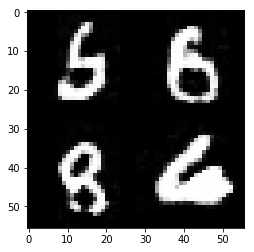

Epoch 2/2 ,  Batch 55500/60000 :  Discriminator Loss: 0.9910... Generator Loss: 0.9260
Epoch 2/2 ,  Batch 56000/60000 :  Discriminator Loss: 0.8695... Generator Loss: 1.0450
Epoch 2/2 ,  Batch 56500/60000 :  Discriminator Loss: 1.5113... Generator Loss: 0.4461
Epoch 2/2 ,  Batch 57000/60000 :  Discriminator Loss: 0.7890... Generator Loss: 1.0990
Epoch 2/2 ,  Batch 57500/60000 :  Discriminator Loss: 1.2517... Generator Loss: 0.6790
Epoch 2/2 ,  Batch 58000/60000 :  Discriminator Loss: 0.9529... Generator Loss: 0.9945
Epoch 2/2 ,  Batch 58500/60000 :  Discriminator Loss: 0.9103... Generator Loss: 0.9041
Epoch 2/2 ,  Batch 59000/60000 :  Discriminator Loss: 1.6518... Generator Loss: 0.3517
Epoch 2/2 ,  Batch 59500/60000 :  Discriminator Loss: 1.0276... Generator Loss: 0.7381
Epoch 2/2 ,  Batch 0/60000 :  Discriminator Loss: 0.9144... Generator Loss: 0.9877


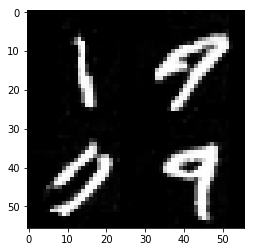

GRAPH:


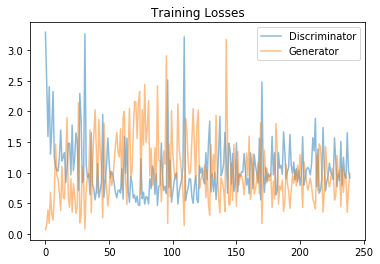

EPOCH 2/2, generations: 


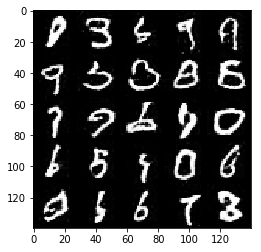

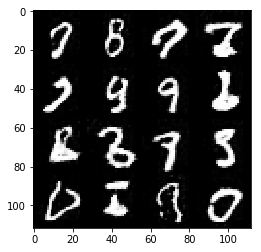

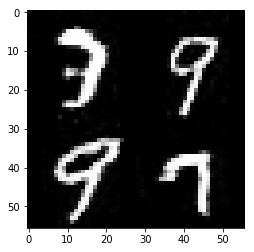

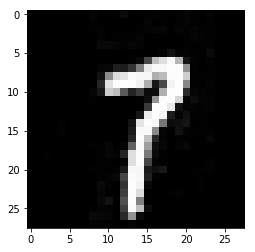

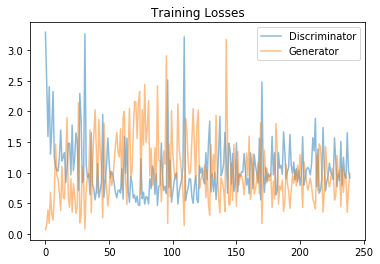

In [15]:
batch_size = 10
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, 
          n_images=4, print_every=50, show_every=500, show_graph_every=1500)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1 ,  Batch 3200/202599 :  Discriminator Loss: 1.4695... Generator Loss: 0.6017
Epoch 1/1 ,  Batch 6400/202599 :  Discriminator Loss: 1.5156... Generator Loss: 0.9571
Epoch 1/1 ,  Batch 9600/202599 :  Discriminator Loss: 1.5314... Generator Loss: 0.8851
Epoch 1/1 ,  Batch 12800/202599 :  Discriminator Loss: 1.4335... Generator Loss: 0.7087
Epoch 1/1 ,  Batch 16000/202599 :  Discriminator Loss: 1.4108... Generator Loss: 1.1075
Epoch 1/1 ,  Batch 19200/202599 :  Discriminator Loss: 1.3995... Generator Loss: 0.7643
Epoch 1/1 ,  Batch 22400/202599 :  Discriminator Loss: 1.3594... Generator Loss: 0.7649
Epoch 1/1 ,  Batch 25600/202599 :  Discriminator Loss: 1.2923... Generator Loss: 0.7504
Epoch 1/1 ,  Batch 28800/202599 :  Discriminator Loss: 1.5226... Generator Loss: 0.5884
Epoch 1/1 ,  Batch 32000/202599 :  Discriminator Loss: 1.4107... Generator Loss: 0.6245


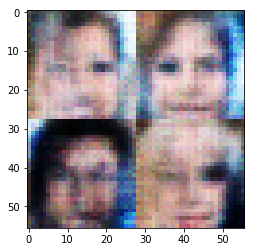

Epoch 1/1 ,  Batch 35200/202599 :  Discriminator Loss: 1.4951... Generator Loss: 0.7438
Epoch 1/1 ,  Batch 38400/202599 :  Discriminator Loss: 1.6746... Generator Loss: 0.9735
Epoch 1/1 ,  Batch 41600/202599 :  Discriminator Loss: 1.5248... Generator Loss: 0.7644
Epoch 1/1 ,  Batch 44800/202599 :  Discriminator Loss: 1.4953... Generator Loss: 0.7576
Epoch 1/1 ,  Batch 48000/202599 :  Discriminator Loss: 1.5448... Generator Loss: 0.6398
Epoch 1/1 ,  Batch 51200/202599 :  Discriminator Loss: 1.4947... Generator Loss: 0.7398
Epoch 1/1 ,  Batch 54400/202599 :  Discriminator Loss: 1.4409... Generator Loss: 0.7675
Epoch 1/1 ,  Batch 57600/202599 :  Discriminator Loss: 1.4105... Generator Loss: 0.8092
Epoch 1/1 ,  Batch 60800/202599 :  Discriminator Loss: 1.4366... Generator Loss: 0.6991
Epoch 1/1 ,  Batch 64000/202599 :  Discriminator Loss: 1.4238... Generator Loss: 0.8077


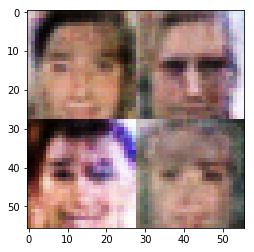

Epoch 1/1 ,  Batch 67200/202599 :  Discriminator Loss: 1.4446... Generator Loss: 0.7709
Epoch 1/1 ,  Batch 70400/202599 :  Discriminator Loss: 1.6389... Generator Loss: 0.9411
Epoch 1/1 ,  Batch 73600/202599 :  Discriminator Loss: 1.4667... Generator Loss: 0.7388
Epoch 1/1 ,  Batch 76800/202599 :  Discriminator Loss: 1.3495... Generator Loss: 0.7702
Epoch 1/1 ,  Batch 80000/202599 :  Discriminator Loss: 1.3746... Generator Loss: 0.7504
Epoch 1/1 ,  Batch 83200/202599 :  Discriminator Loss: 1.5096... Generator Loss: 0.5871
Epoch 1/1 ,  Batch 86400/202599 :  Discriminator Loss: 1.3520... Generator Loss: 0.9238
Epoch 1/1 ,  Batch 89600/202599 :  Discriminator Loss: 1.4533... Generator Loss: 0.7573
Epoch 1/1 ,  Batch 92800/202599 :  Discriminator Loss: 1.4187... Generator Loss: 0.9326
Epoch 1/1 ,  Batch 96000/202599 :  Discriminator Loss: 1.4735... Generator Loss: 0.6472


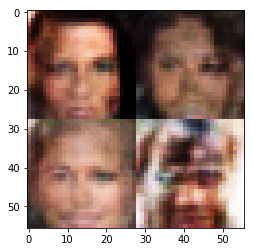

Epoch 1/1 ,  Batch 99200/202599 :  Discriminator Loss: 1.4590... Generator Loss: 0.7336
Epoch 1/1 ,  Batch 102400/202599 :  Discriminator Loss: 1.4176... Generator Loss: 0.9449
Epoch 1/1 ,  Batch 105600/202599 :  Discriminator Loss: 1.3455... Generator Loss: 0.8175
Epoch 1/1 ,  Batch 108800/202599 :  Discriminator Loss: 1.4253... Generator Loss: 0.9315
Epoch 1/1 ,  Batch 112000/202599 :  Discriminator Loss: 1.3722... Generator Loss: 0.7794
Epoch 1/1 ,  Batch 115200/202599 :  Discriminator Loss: 1.4414... Generator Loss: 0.6110
Epoch 1/1 ,  Batch 118400/202599 :  Discriminator Loss: 1.3880... Generator Loss: 0.7001
Epoch 1/1 ,  Batch 121600/202599 :  Discriminator Loss: 1.4668... Generator Loss: 0.5641
Epoch 1/1 ,  Batch 124800/202599 :  Discriminator Loss: 1.3759... Generator Loss: 0.9518
Epoch 1/1 ,  Batch 128000/202599 :  Discriminator Loss: 1.4254... Generator Loss: 0.8040


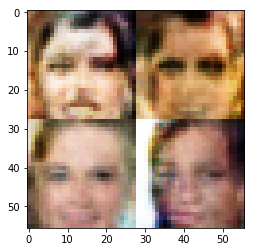

Epoch 1/1 ,  Batch 131200/202599 :  Discriminator Loss: 1.4100... Generator Loss: 0.9715
Epoch 1/1 ,  Batch 134400/202599 :  Discriminator Loss: 1.3983... Generator Loss: 0.7738
Epoch 1/1 ,  Batch 137600/202599 :  Discriminator Loss: 1.3956... Generator Loss: 0.8091
Epoch 1/1 ,  Batch 140800/202599 :  Discriminator Loss: 1.4022... Generator Loss: 0.7427
Epoch 1/1 ,  Batch 144000/202599 :  Discriminator Loss: 1.5015... Generator Loss: 0.7457
Epoch 1/1 ,  Batch 147200/202599 :  Discriminator Loss: 1.4981... Generator Loss: 0.6050
Epoch 1/1 ,  Batch 150400/202599 :  Discriminator Loss: 1.4168... Generator Loss: 0.7072
Epoch 1/1 ,  Batch 153600/202599 :  Discriminator Loss: 1.4766... Generator Loss: 0.7178
Epoch 1/1 ,  Batch 156800/202599 :  Discriminator Loss: 1.3624... Generator Loss: 0.9133
Epoch 1/1 ,  Batch 160000/202599 :  Discriminator Loss: 1.4999... Generator Loss: 0.7427


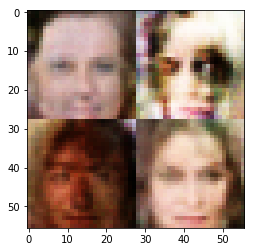

Epoch 1/1 ,  Batch 163200/202599 :  Discriminator Loss: 1.5648... Generator Loss: 0.6337
Epoch 1/1 ,  Batch 166400/202599 :  Discriminator Loss: 1.4503... Generator Loss: 0.6184
Epoch 1/1 ,  Batch 169600/202599 :  Discriminator Loss: 1.4751... Generator Loss: 0.6892
Epoch 1/1 ,  Batch 172800/202599 :  Discriminator Loss: 1.4528... Generator Loss: 0.8458
Epoch 1/1 ,  Batch 176000/202599 :  Discriminator Loss: 1.4353... Generator Loss: 0.6661
Epoch 1/1 ,  Batch 179200/202599 :  Discriminator Loss: 1.3377... Generator Loss: 0.8422
Epoch 1/1 ,  Batch 182400/202599 :  Discriminator Loss: 1.5853... Generator Loss: 0.6896
Epoch 1/1 ,  Batch 185600/202599 :  Discriminator Loss: 1.5145... Generator Loss: 0.6803
Epoch 1/1 ,  Batch 188800/202599 :  Discriminator Loss: 1.5256... Generator Loss: 0.8809
Epoch 1/1 ,  Batch 192000/202599 :  Discriminator Loss: 1.5152... Generator Loss: 0.8330


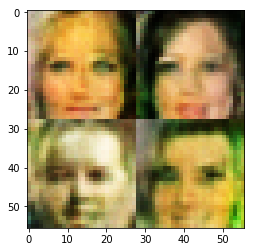

GRAPH:


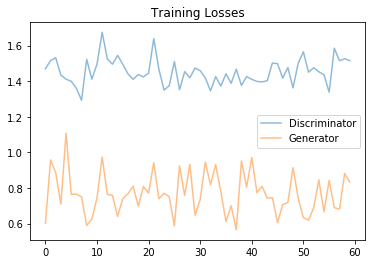

Epoch 1/1 ,  Batch 195200/202599 :  Discriminator Loss: 1.4319... Generator Loss: 0.7551
Epoch 1/1 ,  Batch 198400/202599 :  Discriminator Loss: 1.4745... Generator Loss: 0.6229
Epoch 1/1 ,  Batch 201600/202599 :  Discriminator Loss: 1.3909... Generator Loss: 0.7673
EPOCH 1/1, generations: 


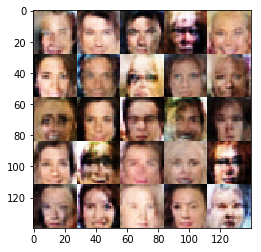

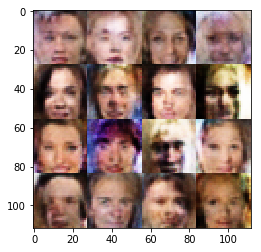

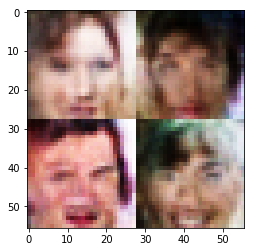

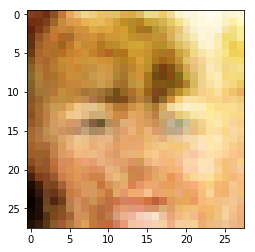

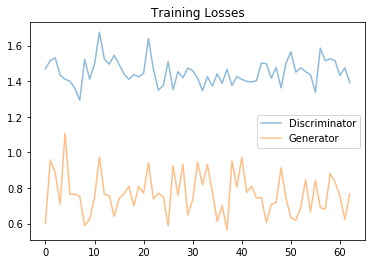

In [16]:
batch_size = 128 # 96 # 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, 
          n_images=4, print_every=25, show_every=250, show_graph_every=1500)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.